In [8]:
import os

import rasterio 
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask

!pip install geopandas
import geopandas as gpd
import pandas as pd
import numpy as np

Defaulting to user installation because normal site-packages is not writeable


In [3]:
BASE_DIR = os.getcwd()
print(f"BASE_DIR is: {BASE_DIR}")
DATASET_DIR = f"/share/Summer-School-2024/Team5/datasets"
REPROJECT_PATH = f"{BASE_DIR}/reprojected-datasets"
OUTPUT_PATH = f"{BASE_DIR}/outputs"

BASE_DIR is: /home/jovyan/hs-iguide


In [4]:
nri_columns = [
        'TRACTFIPS',
        'POPULATION',
        'BUILDVALUE',
        'AGRIVALUE',
        'WFIR_AFREQ',
        'WFIR_EXPB',
        'WFIR_EXPP',
        'WFIR_EXPPE',
        'WFIR_EXPA',
        'WFIR_EXPT',
        'WFIR_HLRB',
        'WFIR_HLRP',
        'WFIR_HLRA',
        'WFIR_HLRR',
        'WFIR_EALB',
    ]

feature_dict_list = [
    {
        "file_name": f"{DATASET_DIR}/ClimateEngineTifs/DAYMET_Precipitation_JJA.tif",
        "feature_name": "Precipitation",
        "reprojected_file_name": f"{REPROJECT_PATH}/Precipitation.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/ClimateEngineTifs/DAYMET_tmax_JJA.tif",
        "feature_name": "Max-Temperature",
        "reprojected_file_name": f"{REPROJECT_PATH}/MaxTemperature.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/ClimateEngineTifs/DAYMET_tmin_JJA.tif",
        "feature_name": "Min-Temperature",
        "reprojected_file_name": f"{REPROJECT_PATH}/MinTemperature.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/ClimateEngineTifs/DAYMET_tmean_JJA.tif",
        "feature_name": "Mean-Temperature",
        "reprojected_file_name": f"{REPROJECT_PATH}/MeanTemperature.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/ClimateEngineTifs/DAYMET_HargreavesPotentialEvapotranspiration_JJA.tif",
        "feature_name": "Potential-Evapotranspiration",
        "reprojected_file_name": f"{REPROJECT_PATH}/PotentialEvapotranspiration.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX2/BuildingCount_TX.tif",
        "feature_name": "Building-Count",
        "reprojected_file_name": f"{REPROJECT_PATH}/BuildingCount.tif",
        "method": "sum"
    },
    {
        "file_name": f"{DATASET_DIR}/TX2/BuildingCover_TX.tif",
        "feature_name": "Building-Cover",
        "reprojected_file_name": f"{REPROJECT_PATH}/BuildingCover.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX2/BuildingDensity_TX.tif",
        "feature_name": "Building-Density",
        "reprojected_file_name": f"{REPROJECT_PATH}/BuildingDensity.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX2/HUCount_TX.tif",
        "feature_name": "Housing-Unit-Count",
        "reprojected_file_name": f"{REPROJECT_PATH}/HUCount.tif",
        "method": "sum"
    },
    {
        "file_name": f"{DATASET_DIR}/TX2/HUDen_TX.tif",
        "feature_name": "Housing-Unit-Density",
        "reprojected_file_name": f"{REPROJECT_PATH}/HUDen.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX2/HUExposure_TX.tif",
        "feature_name": "Housing-Unit-Exposure",
        "reprojected_file_name": f"{REPROJECT_PATH}/HUExposure.tif",
        "method": "sum"
    },
    
    {
        "file_name": f"{DATASET_DIR}/TX2/PopDen_TX.tif",
        "feature_name": "Population-Density",
        "reprojected_file_name": f"{REPROJECT_PATH}/PopDen.tif",
        "method": "mean"
    },

    {
        "file_name": f"{DATASET_DIR}/TX/CFL_TX.tif",
        "feature_name": "Conditional-Flame-Length",
        "reprojected_file_name": f"{REPROJECT_PATH}/CFL.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX/CRPS_TX.tif",
        "feature_name": "Conditional-Risk-2-Potential-Structures",
        "reprojected_file_name": f"{REPROJECT_PATH}/CRPS.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX/FLEP4_TX.tif",
        "feature_name": "Flame-Length-Over-4-Feet",
        "reprojected_file_name": f"{REPROJECT_PATH}/FLEP4.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX/FLEP8_TX.tif",
        "feature_name": "Flame-Length-Over-8-Feet",
        "reprojected_file_name": f"{REPROJECT_PATH}/FLEP8.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX/RPS_TX.tif",
        "feature_name": "Risk-2-Potential-Structures",
        "reprojected_file_name": f"{REPROJECT_PATH}/RPS.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX/BP_TX.tif",
        "feature_name": "Burn-Probability",
        "reprojected_file_name": f"{REPROJECT_PATH}/BP.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX/Exposure_TX.tif",
        "feature_name": "Exposure-type",
        "reprojected_file_name": f"{REPROJECT_PATH}/Exposure.tif",
        "method": "mean"
    },
]

In [5]:
import os

import rasterio 
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask

!pip install geopandas
import geopandas as gpd
import pandas as pd
import numpy as np


Defaulting to user installation because normal site-packages is not writeable


In [6]:
def reproject_tif(target_crs, source_tif_path, output_tif_path):
    with rasterio.open(source_tif_path) as src:
        transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        with rasterio.open(output_tif_path, 'w', **kwargs) as dst:
            print(f"Reprojecting {source_tif_path} to {output_tif_path}...")
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest)

In [7]:
# reprojection
# this doesn't need to run because reprojected datasets have been uploaded to shared folder: {DATASET_DIR}
census_tracts = gpd.read_file(f"{DATASET_DIR}/tl_2023_48_tract/tl_2023_48_tract.shp")

target_crs = census_tracts.crs

for feature_dict in feature_dict_list:
    reproject_tif(target_crs, feature_dict["file_name"], feature_dict["reprojected_file_name"])


Reprojecting /share/Summer-School-2024/Team5/datasets/ClimateEngineTifs/DAYMET_Precipitation_JJA.tif to /home/jovyan/hs-iguide/reprojected-datasets/Precipitation.tif...
Reprojecting /share/Summer-School-2024/Team5/datasets/ClimateEngineTifs/DAYMET_tmax_JJA.tif to /home/jovyan/hs-iguide/reprojected-datasets/MaxTemperature.tif...
Reprojecting /share/Summer-School-2024/Team5/datasets/ClimateEngineTifs/DAYMET_tmin_JJA.tif to /home/jovyan/hs-iguide/reprojected-datasets/MinTemperature.tif...
Reprojecting /share/Summer-School-2024/Team5/datasets/ClimateEngineTifs/DAYMET_tmean_JJA.tif to /home/jovyan/hs-iguide/reprojected-datasets/MeanTemperature.tif...
Reprojecting /share/Summer-School-2024/Team5/datasets/ClimateEngineTifs/DAYMET_HargreavesPotentialEvapotranspiration_JJA.tif to /home/jovyan/hs-iguide/reprojected-datasets/PotentialEvapotranspiration.tif...
Reprojecting /share/Summer-School-2024/Team5/datasets/TX2/BuildingCount_TX.tif to /home/jovyan/hs-iguide/reprojected-datasets/BuildingCount

In [8]:
# Aggregation
def add_column_by_feature(gdf, feature_dict):
    raster = rasterio.open(feature_dict["reprojected_file_name"])
    print(f"Fetching values for {feature_dict['feature_name']}...")
    value_list = []
    for _, row in gdf.iterrows():
        geom = [row['geometry'].__geo_interface__]
        out_image, out_transform = mask(raster, geom, crop=True)
        masked = np.ma.masked_array(out_image, out_image == raster.nodata)
        if feature_dict["method"] == "sum":
            sum_value = masked.sum()
            # row[feature_name] = sum_value
            value_list.append(sum_value)
        elif feature_dict["method"] == "mean":
            mean_value = masked.mean()
            # row[feature_name] = mean_value
            value_list.append(mean_value)

    raster.close()
    print(f"Adding {feature_dict['feature_name']} to the GeoDataFrame...")
    gdf.insert(2, feature_dict["feature_name"], value_list)

In [9]:
census_tracts_gdf = gpd.read_file(f"{DATASET_DIR}/tl_2023_48_tract/tl_2023_48_tract.shp")
census_tracts_columns = ['GEOID', 'geometry']
census_tracts_gdf = census_tracts_gdf[census_tracts_columns]

# Initialize a list to store the results
results = []

for _, tract in census_tracts_gdf.iterrows():
    # Extract the geometry in GeoJSON format
    geom = [tract['geometry'].__geo_interface__]

    results.append({
        'GeoId': tract['GEOID'],  # Assuming 'GEOID' is the identifier for the census tract
        'geometry': tract['geometry']  # Add the geometry to the result
    })

gdf = gpd.GeoDataFrame(
    results,
    geometry='geometry',
    crs=census_tracts_gdf.crs  # Use the same CRS as the census tracts
)

gdf['GeoId'] = gdf['GeoId'].astype("int64")

gdf.head()

,GeoId,geometry
0,48157674100,"POLYGON ((-95.61467 29.57828, -95.61339 29.578..."
1,48157674200,"POLYGON ((-95.63989 29.58625, -95.63974 29.586..."
2,48441013501,"POLYGON ((-100.15192 32.08412, -100.15188 32.0..."
3,48441013602,"POLYGON ((-100.14955 32.2816, -100.1495 32.286..."
4,48441013601,"POLYGON ((-100.03974 32.48854, -100.03064 32.4..."


In [10]:
# load NRI data
nri_df = pd.read_csv(f"{DATASET_DIR}/NRI/NRI_Table_CensusTracts_Texas.csv")
nri_df = nri_df[nri_columns]

nri_df.head()

,TRACTFIPS,POPULATION,BUILDVALUE,AGRIVALUE,WFIR_AFREQ,WFIR_EXPB,WFIR_EXPP,WFIR_EXPPE,WFIR_EXPA,WFIR_EXPT,WFIR_HLRB,WFIR_HLRP,WFIR_HLRA,WFIR_HLRR,WFIR_EALB
0,48001950100,4625,1.032150e+09,14101899.0,0.000717,1.563828e+08,704.509103,8.172306e+09,2.364991e+06,8.331053e+09,0.4,0.000098,0.003613,Relatively Low,41609.963598
1,48001950401,5755,2.146266e+08,946654.0,0.000307,7.118218e+06,33.642175,3.902492e+08,1.852232e+05,3.975527e+08,0.4,0.000098,0.003613,Relatively Low,836.593057
2,48001950402,7115,3.358006e+08,3963665.0,0.000459,7.348517e+06,168.905754,1.959307e+09,8.070112e+05,1.967462e+09,0.4,0.000098,0.003613,Very Low,984.041588
3,48001950500,4479,6.625227e+08,257077.0,0.000114,3.472231e+07,225.768820,2.618918e+09,1.557468e+04,2.653656e+09,0.4,0.000098,0.003613,Very Low,345.038870
4,48001950600,6036,9.216131e+08,274058.0,0.000638,2.320527e+07,244.657193,2.838023e+09,3.922292e+04,2.861268e+09,0.4,0.000098,0.003613,Very Low,2699.934152


In [11]:
# merge NRI data with census tract data
merged_gdf = gdf.merge(
    nri_df, left_on='GeoId', right_on='TRACTFIPS', how='left')

# clean null rows
merged_gdf = merged_gdf.dropna(subset=nri_columns)

merged_gdf.head()

,GeoId,geometry,TRACTFIPS,POPULATION,BUILDVALUE,AGRIVALUE,WFIR_AFREQ,WFIR_EXPB,WFIR_EXPP,WFIR_EXPPE,WFIR_EXPA,WFIR_EXPT,WFIR_HLRB,WFIR_HLRP,WFIR_HLRA,WFIR_HLRR,WFIR_EALB
0,48157674100,"POLYGON ((-95.61467 29.57828, -95.61339 29.578...",4.815767e+10,6732.0,1.043740e+09,9833.0,0.000010,2.401978e+07,96.338934,1.117532e+09,0.000000e+00,1.141551e+09,0.4,0.000604,0.030198,Relatively Low,96.079121
1,48157674200,"POLYGON ((-95.63989 29.58625, -95.63974 29.586...",4.815767e+10,5179.0,1.537306e+09,3390.0,0.000010,9.481078e+07,268.833563,3.118469e+09,0.000000e+00,3.213280e+09,0.4,0.000604,0.030198,Relatively Moderate,379.243129
2,48441013501,"POLYGON ((-100.15192 32.08412, -100.15188 32.0...",4.844101e+10,2389.0,7.002959e+08,7073207.0,0.003839,3.346794e+08,1114.287022,1.292573e+10,1.838134e+06,1.326225e+10,0.4,0.000066,0.010259,Relatively Moderate,742196.438481
3,48441013602,"POLYGON ((-100.14955 32.2816, -100.1495 32.286...",4.844101e+10,2572.0,6.308193e+08,10778372.0,0.004084,1.944734e+08,866.266151,1.004869e+10,1.423031e+06,1.024458e+10,0.4,0.000066,0.010259,Relatively Low,404450.153379
4,48441013601,"POLYGON ((-100.03974 32.48854, -100.03064 32.4...",4.844101e+10,2996.0,6.610785e+08,433798.0,0.000905,4.563034e+07,291.916874,3.386236e+09,2.380856e+04,3.431890e+09,0.4,0.000066,0.010259,Very Low,15632.203216


In [12]:
merged_gdf.describe()

,GeoId,TRACTFIPS,POPULATION,BUILDVALUE,AGRIVALUE,WFIR_AFREQ,WFIR_EXPB,WFIR_EXPP,WFIR_EXPPE,WFIR_EXPA,WFIR_EXPT,WFIR_HLRB,WFIR_HLRP,WFIR_HLRA,WFIR_EALB
count,6.883000e+03,6.883000e+03,6883.000000,6.883000e+03,6.883000e+03,6883.000000,6.883000e+03,6883.000000,6.883000e+03,6.883000e+03,6.883000e+03,6.883000e+03,6883.000000,6883.000000,6.883000e+03
mean,4.822892e+10,4.822892e+10,4227.762604,7.022567e+08,4.153339e+06,0.000546,6.829160e+07,367.102850,4.258393e+09,8.634936e+05,4.327548e+09,4.000000e-01,0.000301,0.012679,3.325921e+04
std,1.438381e+08,1.438381e+08,2017.405365,8.164234e+08,3.982486e+07,0.001245,1.563668e+08,522.280637,6.058455e+09,1.144108e+07,6.148436e+09,5.107397e-14,0.000361,0.012421,1.341023e+05
min,4.800195e+10,4.800195e+10,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e-01,0.000002,0.000002,0.000000e+00
25%,4.811302e+10,4.811302e+10,2859.500000,3.856084e+08,0.000000e+00,0.000010,6.914014e+06,35.997512,4.175711e+08,0.000000e+00,4.300134e+08,4.000000e-01,0.000033,0.000792,4.346028e+01
50%,4.820142e+10,4.820142e+10,3957.000000,5.788933e+08,1.252000e+03,0.000016,2.969097e+07,196.599851,2.280558e+09,0.000000e+00,2.311612e+09,4.000000e-01,0.000103,0.011258,3.014847e+02
75%,4.835500e+10,4.835500e+10,5191.000000,8.457129e+08,2.641325e+05,0.000514,7.803350e+07,476.775649,5.530598e+09,4.058750e+04,5.617622e+09,4.000000e-01,0.000604,0.030198,1.165616e+04
max,4.850795e+10,4.850795e+10,30199.000000,4.717916e+10,1.875880e+09,0.015542,8.815399e+09,7847.459969,9.103054e+10,6.616625e+08,9.188689e+10,4.000000e-01,0.002898,0.068980,2.801460e+06


In [13]:
for feature_dict in feature_dict_list:
    add_column_by_feature(merged_gdf, feature_dict)
    # add_column_by_feature(gdf, feature_dict["reprojected_file_name"], feature_dict["feature_name"])

# change columns from string to float

merged_gdf['Min-Temperature'] = merged_gdf['Min-Temperature'].apply(lambda x: np.nan if np.ma.is_masked(x) else x).astype("float64")
merged_gdf['Max-Temperature'] = merged_gdf['Max-Temperature'].apply(lambda x: np.nan if np.ma.is_masked(x) else x).astype("float64")
merged_gdf['Mean-Temperature'] = merged_gdf['Mean-Temperature'].apply(lambda x: np.nan if np.ma.is_masked(x) else x).astype("float64")

merged_gdf = merged_gdf.convert_dtypes()
print(merged_gdf.dtypes)

Fetching values for Precipitation...
Adding Precipitation to the GeoDataFrame...
Fetching values for Max-Temperature...
Adding Max-Temperature to the GeoDataFrame...
Fetching values for Min-Temperature...
Adding Min-Temperature to the GeoDataFrame...
Fetching values for Mean-Temperature...
Adding Mean-Temperature to the GeoDataFrame...
Fetching values for Potential-Evapotranspiration...
Adding Potential-Evapotranspiration to the GeoDataFrame...
Fetching values for Building-Count...
Adding Building-Count to the GeoDataFrame...
Fetching values for Building-Cover...
Adding Building-Cover to the GeoDataFrame...
Fetching values for Building-Density...
Adding Building-Density to the GeoDataFrame...
Fetching values for Housing-Unit-Count...
Adding Housing-Unit-Count to the GeoDataFrame...
Fetching values for Housing-Unit-Density...
Adding Housing-Unit-Density to the GeoDataFrame...
Fetching values for Housing-Unit-Exposure...
Adding Housing-Unit-Exposure to the GeoDataFrame...
Fetching values

In [14]:
merged_gdf.shape

(6883, 36)

In [15]:
merged_gdf.to_file(f"{OUTPUT_PATH}/results.geojson", driver='GeoJSON')

In [13]:
import os 
os.getcwd()
hs-iguide/outputs/results.geojson

'/home/jovyan/hs-iguide'

            GeoId  Exposure-type  Burn-Probability  \
0     48157674100       0.143601          0.000013   
1     48157674200       0.257008          0.000046   
2     48441013501       0.870203          0.003103   
3     48441013602       0.707624          0.002678   
4     48441013601       0.391720          0.000694   
...           ...            ...               ...   
6878  48061012700       0.515126          0.002880   
6879  48061013203       0.170424          0.000186   
6880  48061012508       0.292111          0.000263   
6881  48061011903       0.223237          0.000195   
6882  48061014002       0.000000          0.000000   

      Risk-2-Potential-Structures  Flame-Length-Over-8-Feet  \
0                        0.000291                  0.000000   
1                        0.000875                  0.000000   
2                        0.123327                  0.024073   
3                        0.113393                  0.031639   
4                        0.027320   

<Axes: >

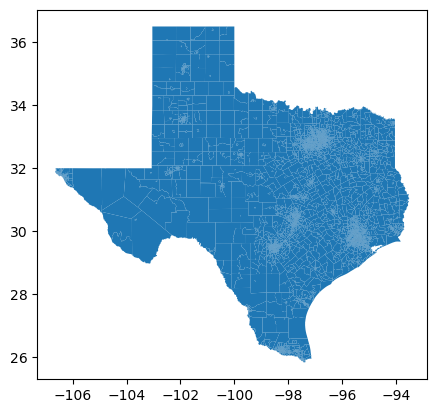

In [14]:
# Path to the GeoJSON file
geojson_file = '/home/jovyan/hs-iguide/outputs/results.geojson'

# Read the GeoJSON file
gdf = gpd.read_file(geojson_file)

# Print the GeoDataFrame
print(gdf)

# Plot the GeoDataFrame
gdf.plot()

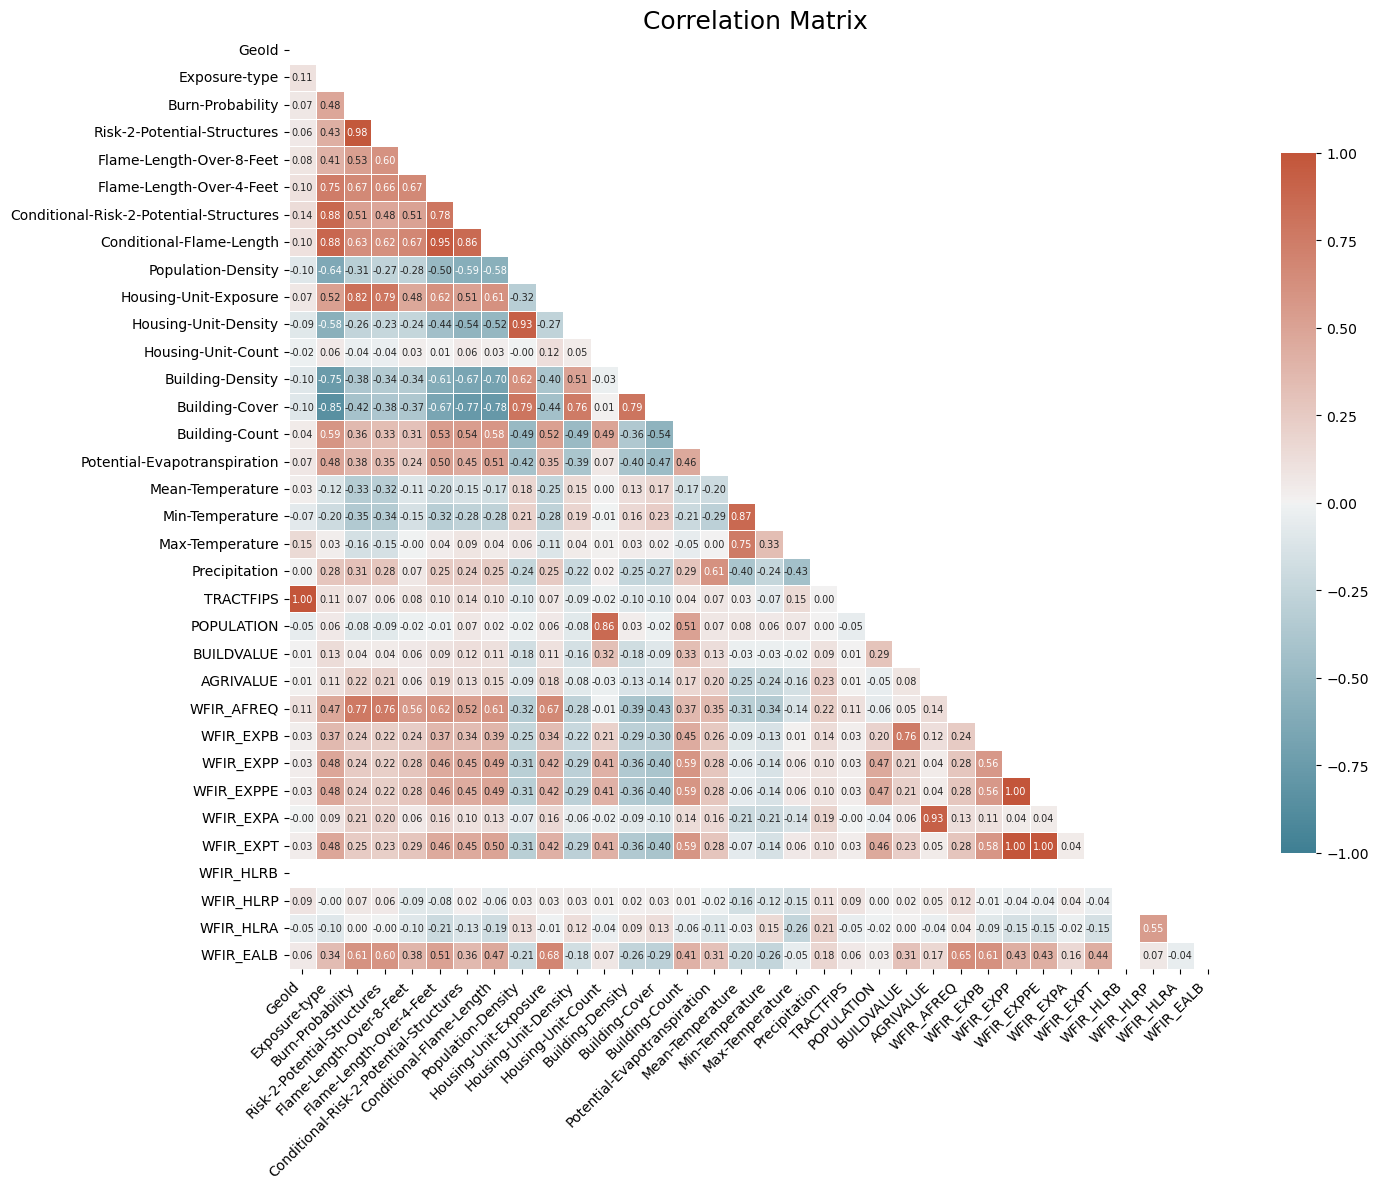

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop geometry column to compute correlation only on attribute data
gdf_attributes = gdf.drop(columns='geometry')

# Select only numeric columns
numeric_columns = gdf_attributes.select_dtypes(include=['number']).columns
gdf_numeric = gdf_attributes[numeric_columns]

# Compute the correlation matrix
correlation_matrix = gdf_numeric.corr()

# Print the correlation matrix
#print("Correlation Matrix:")
#print(correlation_matrix)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            annot=True, fmt='.2f', annot_kws={"size": 7}, square=True, linewidths=0.5, cbar_kws={"shrink": 0.75})

# Add title and adjust layout
plt.title('Correlation Matrix', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

Mean Squared Error: 69619.8399558829
R^2 Score: 0.8716676312489293


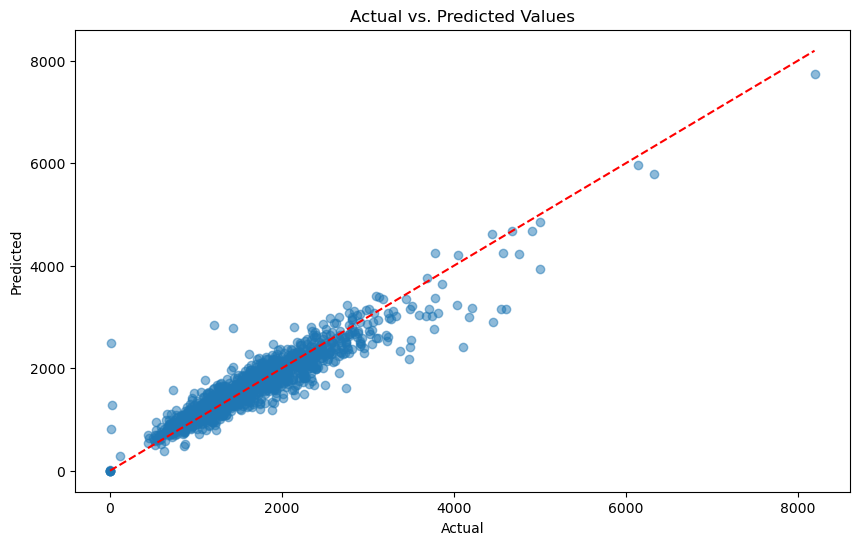

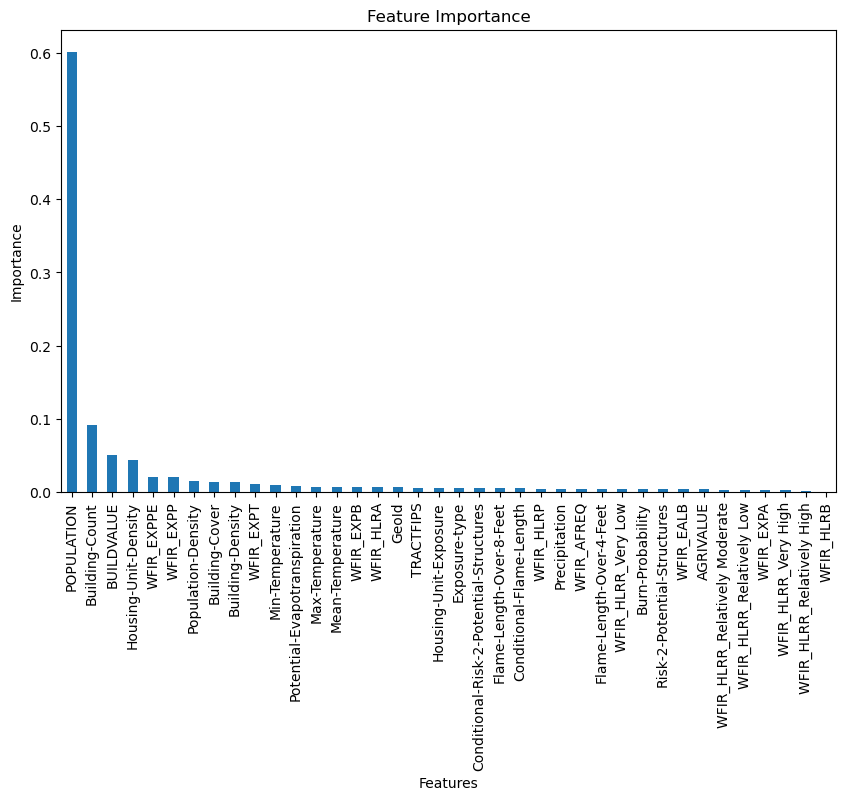

In [54]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import joblib

# Drop geometry column to focus on attribute data
gdf_attributes = gdf.drop(columns='geometry')

# Assume 'target_var' is the dependent variable and the rest are predictors
target_var = 'Housing-Unit-Count'  # Replace with your actual target variable

# Ensure the target variable is in the DataFrame
if target_var not in gdf_attributes.columns:
    raise ValueError(f"Target variable '{target_var}' not found in the DataFrame columns.")

# Convert categorical variables to dummy variables (one-hot encoding)
gdf_dummies = pd.get_dummies(gdf_attributes, drop_first=True)

# Drop columns with all missing values
gdf_dummies = gdf_dummies.dropna(axis=1, how='all')

# Separate dependent (target) and independent (predictor) variables
y = gdf_dummies[target_var]
X = gdf_dummies.drop(columns=[target_var])

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Initialize the Extra Trees Regressor
et = ExtraTreesRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
et.fit(X_train, y_train)

# Save the model
joblib.dump(et, 'extra_trees_regressor_model.joblib')

# Predict on the test data
y_pred = et.predict(X_test)

# Save the results to a CSV file
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results.to_csv('extra_trees_predictions.csv', index=False)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

# Feature importance
feature_importances = pd.Series(et.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()